#### Pakkar

In [1]:
# Our Libraries 
from ourModules import text_processor
from ourModules import toxic_comment_Classifier

/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [858]:
# Libraries ---------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction import stop_words
import string
from tensorflow.python.keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras.optimizers import Adadelta
import scipy.sparse
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn


from matplotlib.colors import Normalize
import warnings; 
# # %tensorflow_version 1.x
# import tensorflow
# print(tensorflow.__version__)
import tensorflow as tf

In [4]:
tf.compat.v1.disable_eager_execution()

#### Innlestur gagna

In [5]:
train_data = pd.read_csv('data/train.csv',delimiter=',')
train_data.drop('id',axis=1,inplace=True) # Id er gagnslaust til ad spa
# test_labeled_data = pd.read_csv('data/test_labels.csv',delimiter=',') # Will most likely not be used



### Gagnasettið
Hér má sjá gagnasettið sem við þjálfum módelið á. Við erum með comment_text og hann er búið að greina (0 eða 1) hvort hann sé toxic, severe_toxic, obscene, threat, insult eða identity_hate.

In [886]:
# Nota þetta til að testa loka módelið
cols = list(train_data)
X_train_data = train_data.drop(columns = cols[1:])
y_train_data = train_data.drop(columns = cols[:1])

# 80/20 train/test split
# Mögulega þarf að nota sklearn.cross_validation.StratifiedShuffleSplit frekar til að halda svipuðu 
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=12)
X_train_np, X_test_np, y_train_np, y_test_np = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()


Data subsampling succsessful!
Reducing dimensions...
Plotting PCA projection...


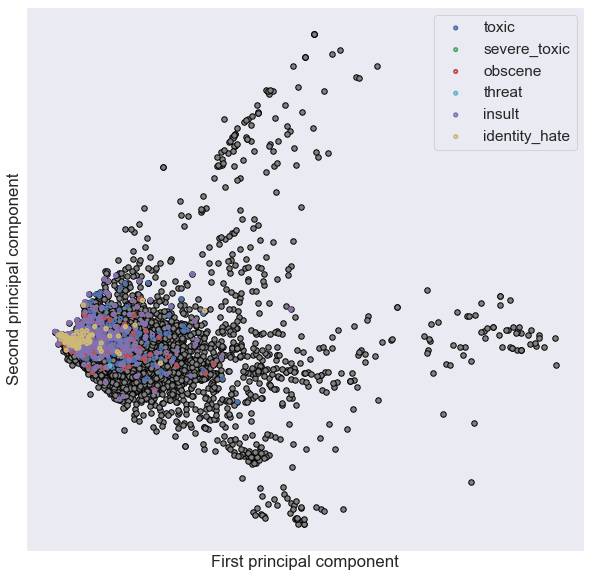

CPU times: user 12.8 s, sys: 2.35 s, total: 15.1 s
Wall time: 5.46 s


In [887]:
%%time
def plot_pca(x_data, y_data, colum_names):
    # PCA reynir að halda punktum langt fra hvor öðrum langt frá hvor öðrum
    print("Reducing dimensions...")
    x_2d = PCA(n_components=2).fit_transform(x_data.todense())

    print("Plotting PCA projection...")
    min_x = np.min(x_2d[:, 0])
    max_x = np.max(x_2d[:, 0])

    min_y = np.min(x_2d[:, 1])
    max_y = np.max(x_2d[:, 1])

    colors_ = ['b', 'g', 'r', 'c', 'm', 'y']
    plt.figure(figsize=(10, 10))
    #plots all the dots
    plt.scatter(x_2d[:, 0], x_2d[:, 1], s=30, c='gray', edgecolors=(0, 0, 0))
    for i in range(len(colum_names)):
        label_ = np.where(y_data[:, i])
        # plots lables as empty coloured circles, each dot can have multiple labels
        plt.scatter(x_2d[label_, 0], x_2d[label_, 1], s=10, edgecolors=colors_[i],
                facecolors='none', linewidths=2, label=colum_names[i])
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)

    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend(loc="upper right")
    plt.autoscale()
    plt.show()
    
# Dimensionality reduction
train_size = 10000

#tekur um sec þús train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)
plot_pca(X_train_reduced, y_train_reduced, cols[1:])


Sjáum frá grafinu og greinilegt er að klasarnir eru nálægt hvor öðrum

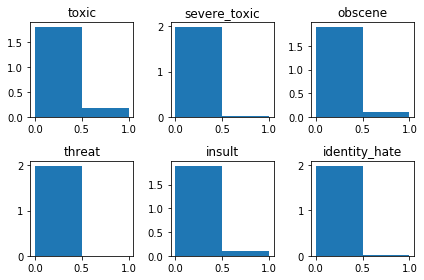

Number of instances marked with toxic: 	 12143/127656 or 9.51%
Number of instances marked with severe_toxic: 	 1265/127656 or 0.99%
Number of instances marked with obscene: 	 6714/127656 or 5.26%
Number of instances marked with threat: 	 387/127656 or 0.30%
Number of instances marked with insult: 	 6275/127656 or 4.92%
Number of instances marked with identity_hate: 	 1117/127656 or 0.88%


In [477]:
# Visualize distribution of y
n_bins = 2
fig, axes = plt.subplots(nrows=2, ncols=3)
axs = axes.flatten()
i = 0
for col in cols[1:]:
    axs[i].hist(y_train[col], n_bins, density=True, histtype='bar')
    axs[i].set_title(col)
    i +=1
fig.tight_layout()
plt.show()
# Notice skewed dataset
for col in cols[1:]:
    cnt = np.count_nonzero(y_train[col])
    print('Number of instances marked with {}: \t {}/{} or {:.2%}'.format(col, cnt,
                                                                    y_train_np.shape[0], cnt/y_train_np.shape[0]) )

In [888]:
def get_row_accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred, axis = 1)
    return np.average(np.where(acc == 6, 1, 0), axis = 0)

n,m = y_train_np.shape
y_pred = np.zeros(n)

rowindx, colindx = np.nonzero(y_train_np)
rwi = np.unique(rowindx)
# print('Number of rows with at least one none-zero value ', len(rwi))
# non_zero_y_train = y_train_np[rwi]
# # for i in range(m):
# #     print('All-zero guess accuracy on data for {} is: {:.2%}'.format(cols[i+1], np.average(y_pred == y_train_np[:, i])))
# #     print('All-zero guess accuracy for {} but all-zero-rows removed is: {:.2%}'.format(cols[i+1],
# #                                                                 np.average(y_pred[rwi] == non_zero_y_train[:, i])))
# #     print('-'*100)

print('All-zero guess row accuracy on data is: {:.2%}'.format(get_row_accuracy(y_train_np, y_pred_mat)))

All-zero guess row accuracy on data is: 89.89%


### State Vector Machine / Baseline Model




Lets build our first model. We start by making a simple SVM, which is widely regarded as one of the best text classification algorithms. This baseline classifier which treats the labels independently by training a binary classifier on each label separately. This initial model does not implement multilable classifaction in the best way nor does it take into account the skewed data.

micro-averaged scores over all classes
F1 score: 0.630, 
AUC score: 0.919
--------------------
macro-averaged scores over all classes
F1 score: 0.372, 
AUC score: 0.911
--------------------


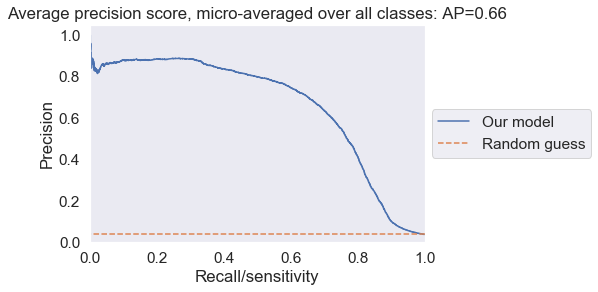

micro-averaged scores over all classes
F1 score: 0.630, 
AUC score: 0.919
--------------------
macro-averaged scores over all classes
F1 score: 0.372, 
AUC score: 0.911
--------------------


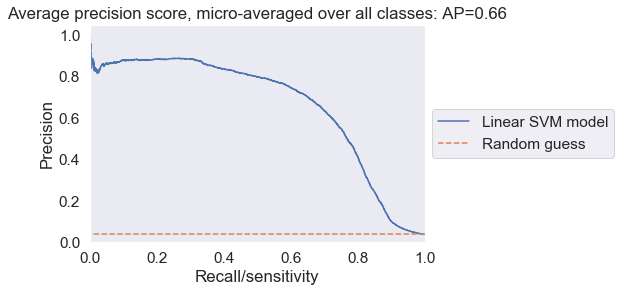

In [855]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def plot_prec_recall(y_true, y_scores, y_pred_, label_='Our model'):
    # calculate F1 score
    for par in ['micro', 'macro']:
        f1 = f1_score(y_true, y_pred_, average = par)
        auc = roc_auc_score(y_true, y_scores, average = par)
        print('{}-averaged scores over all classes'.format(par))
        print("F1 score: {:.3f}, \nAUC score: {:.3f}".format(f1 , auc))
        print('-'*20)
        
    r_model = np.random.randint(2, size=len(y_true.ravel()))
    no_skill = precision_recall_curve(y_true.ravel(), r_model)
    
    # A "micro-average": quantifying score on all classes jointly
    precision, recall, _ = precision_recall_curve(y_true.ravel(),y_scores.ravel())

    average_precision = average_precision_score(y_true, y_scores, average='micro')
    
    plt.figure()

    plt.step(recall, precision, where='post', label=label_)
    plt.step(no_skill[1], no_skill[0], linestyle='--', where='post', label='Random guess')

    plt.xlabel('Recall/sensitivity')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(None)
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={:0.2f}'
        .format(average_precision))
    plt.show()
    
# y_scores = clf.decision_function(vectorizer.transform(X_test_np.ravel()))
calc_precision_recall(y_test_np, y_scores_linear, y_pred_ = y_pred_linear)
plot_prec_recall(y_test_np, y_scores_linear, y_pred_linear, label_='Linear SVM model')

In [805]:
def plot_conf_mat(mat, cmap_="OrRd" ):
    tn, fp, fn, tp  = mat.ravel()
    print('-'*50)
    print("TN: {}\t FP: {} \nFN: {}\t TP: {}".format(tn, fp, fn, tp))
    print("The sensitivity/recall is: {:.2%}".format(tp/(tp+fn)))
    print("The specificity is: {:.2%}".format(tn/(tn+fp)))
    print("The precision is: {:.2%}".format(tp/(tp+fp)))
    print('-'*50)
    ax = sn.heatmap(mat, annot=True, fmt="d", cmap=cmap_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # Lætur tölurnar vera í miðjum kassanum
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

In [92]:

# subsamples the data but makes sure all y columns include 2 classes
def data_subsample_asserts_two_classes(X, y, n):
    # Select a random subset of the training data
    max_tries = 15
    tries = 0
    while tries < max_tries:
        perm = np.random.permutation(len(y))
        X_sub=X[perm[0:n],:]
        y_sub=y[perm[0:n]]
        count = 0
        length = y_sub.shape[1]
        for i in range(length):
            # Make sure all columns have 2 classes
            if len(np.unique(y_sub[:,i])) < 2:
                break
            if i == (length-1):
                print('Data subsampling succsessful!')
                return X_sub, y_sub
        tries += 1
#         print("Data subsampling failed in {} try. Trying again.".format(tries) )
#         print('-'*100)
    print("Data subsampling failed in {} tries".format(max_tries))
    return 0,0


In [837]:

def plot_acc_params(param, train_acc_, val_acc_, param_name, title):
    plt.plot(param, train_acc_,label='Training accuracy')
    plt.plot(param, val_acc_,label='Validation accuracy')
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def find_best_SVM_params(Cs, gammas, kernel_, xtrain, ytrain, xval, yval):
    training_acc = np.zeros(len(Cs))
    val_acc = np.zeros(len(Cs))
    # ignores the gamma values if linear
    if kernel_ != 'linear':
        training_acc = np.zeros((len(Cs), len(gammas)))
        val_acc = np.zeros((len(Cs), len(gammas)))
    
    for i in range(len(Cs)):
        print("c: ", Cs[i])
        if kernel_ != 'linear':
            for j in range(len(gammas)):
                print("gamma: ", gammas[j], end =" ")
                clf = OneVsRestClassifier(SVC(gamma=gammas[j], C = Cs[i], kernel = kernel_))
                clf.fit(xtrain, ytrain)
                val_acc[i, j] = get_row_accuracy(yval, clf.predict(xval))
                training_acc[i, j] = get_row_accuracy(ytrain, clf.predict(xtrain))
            print()
        else:
            clf = OneVsRestClassifier(SVC(C = Cs[i], kernel = kernel_))
            clf.fit(xtrain, ytrain)
            val_acc[i] = get_row_accuracy(yval, clf.predict(xval))
            training_acc[i] = get_row_accuracy(ytrain, clf.predict(xtrain))
#     print('Train acc \n', training_acc)
#     print('Validation acc \n', val_acc)
    return training_acc, val_acc

# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_heatmap(data_matrix, title, xlabel, ylabel, x_values, y_values, vmin_, midpoint_):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(data_matrix, interpolation='nearest', cmap=plt.cm.seismic,
               norm=MidpointNormalize(vmin=vmin_, midpoint=midpoint_))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    
    plt.grid(None)
    plt.xticks(np.arange(len(x_values)), x_values, rotation=45)
    plt.yticks(np.arange(len(y_values)), y_values)
    plt.title(title)
    plt.show()


In [245]:
%%time
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, 5000)
print("Number of training instances: ", X_train_reduced.shape[0])

# Bag of words approach
# CountVectorizer has the benefit of producing a sparse representation of the counts 
vectorizer = CountVectorizer( max_df=0.95, min_df=2, max_features = None, stop_words='english')
tfidf_transformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(X_train_reduced.ravel())
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# Rough search for a good estimate of C and gamma
x_test_unrvld = vectorizer.transform(X_test_np.ravel())

C = 0.01* np.power(10,np.arange(5))
gamma = 1/np.power(10,np.arange(4))

accs = { 'val_acc': {'rbf': np.zeros((len(C), len(gamma))),
                     'linear': np.zeros(len(C)) },
        'train_acc': {'rbf': np.zeros((len(C), len(gamma))),
                     'linear': np.zeros(len(C)) } 
       }
kernels = ['rbf', 'linear']
for kernel in kernels:
    print('-'*100)
    print('Using kernel ', kernel)
    print('Testing parameters, C: {},\ngamma: {}'.format(C, gamma))
    tA, vA = find_best_SVM_params(C, gamma, kernel,
                                     X_train_tfidf, y_train_reduced,
                                     x_test_unrvld, y_test_np)
    accs['train_acc'][kernel] = tA
    accs['val_acc'][kernel] = vA

rbfacc = accs['val_acc']['rbf']; linacc = accs['val_acc']['linear']
Cind, gammaind = np.unravel_index(np.argmax(rbfacc, axis=None), rbfacc.shape)
print('For rbf kernal')
rbfOptparam = C[Cind], gamma[gammaind]
print("Optimal combination is,  C: {}, gamma: {}".format(rbfOptparam[0], rbfOptparam[1]))
print("Giving the validation accuracy: {:.2%}".format(rbfacc[Cind, gammaind]))

Cindex = np.argmax(linacc)
linearOptC = C[Cindex]
print('For linear kernal')
print("Optimal C is: {}".format(linearOptC))
print("Giving the validation accuracy: {:.2%}".format(linacc[Cindex]))

Data subsampling succsessful!
Number of training instances:  5000
----------------------------------------------------------------------------------------------------
Using kernel  rbf
Testing parameters, C: [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02],
gamma: [1.    0.1   0.01  0.001]
c:  0.01
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  0.1
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  1.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  10.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  100.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
----------------------------------------------------------------------------------------------------
Using kernel  linear
Testing parameters, C: [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02],
gamma: [1.    0.1   0.01  0.001]
c:  0.01
c:  0.1
c:  1.0
c:  10.0
c:  100.0
For rbf kernal
Optimal combination is,  C: 10.0, gamma: 0.01
Giving the validation accuracy: 90.94%
For linear kernal
Optimal C is: 0.1
Giving the validation

For rbf kernal
Optimal combination is,  C: 10.0, gamma: 0.01
Giving the validation accuracy: 90.94%
For linear kernal
Optimal C is: 0.1
Giving the validation accuracy: 90.61%


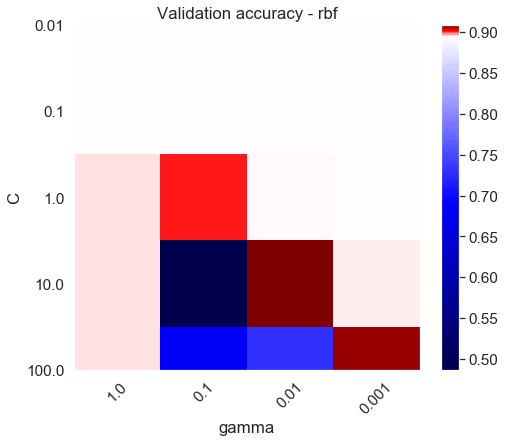

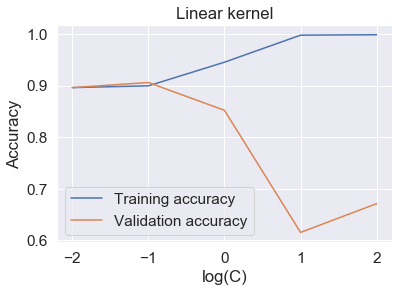

In [838]:
rbfacc = accs['val_acc']['rbf']; linacc = accs['val_acc']['linear']
Cind, gammaind = np.unravel_index(np.argmax(rbfacc, axis=None), rbfacc.shape)
print('For rbf kernal')
rbfOptparam = C[Cind], gamma[gammaind]
print("Optimal combination is,  C: {}, gamma: {}".format(rbfOptparam[0], rbfOptparam[1]))
print("Giving the validation accuracy: {:.2%}".format(rbfacc[Cind, gammaind]))

linearOptC = C[np.argmax(linacc)]
print('For linear kernal')
print("Optimal C is: {}".format(linearOptC))
print("Giving the validation accuracy: {:.2%}".format(linacc[Cindex]))

plot_heatmap(rbfacc, 'Validation accuracy - rbf', 'gamma', 'C', gamma, C,
             np.min(rbfacc) , np.median(rbfacc))
plot_acc_params(np.log10(C), accs['train_acc']['linear'], accs['val_acc']['linear'], 'log(C)', 'Linear kernel')


Training size 15000
Using optimal C: 0.1
Data subsampling succsessful!
Test accuracy on linear kernel 90.98%
F1 score: 0.630, 
AUC score: 0.919


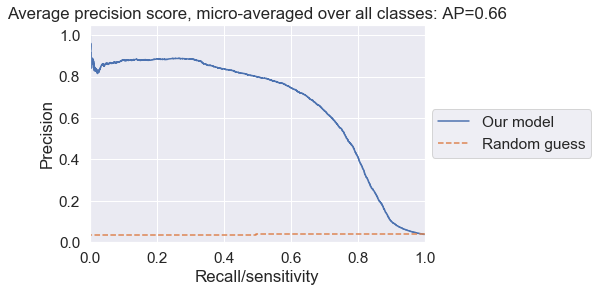

--------------------------------------------------
TN: 183298	 FP: 995 
FN: 3430	 TP: 3767
The sensitivity/recall is: 52.34%
The specificity is: 99.46%
The precision is: 79.11%
--------------------------------------------------


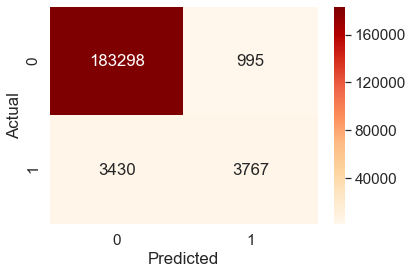

CPU times: user 2min 12s, sys: 1.28 s, total: 2min 13s
Wall time: 2min 4s


In [833]:
%%time
def vectorize_data(X_train_):
    vectorizer = CountVectorizer( max_df=0.95, min_df=2, max_features = None, stop_words='english')
    tfidf_transformer = TfidfTransformer()
    X_train_counts = vectorizer.fit_transform(X_train_.ravel())
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    return X_train_tfidf, vectorizer

# Tekur ca 8min að keyra á 50þus train size
print('Training size', train_size)
print('Using optimal C: {}'.format(linearOptC))

train_size = 15000
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)

x_test_unrvld = vectorizer.transform(X_test_np.ravel())
clf = OneVsRestClassifier(SVC(C = linearOptC, kernel = 'linear'))
clf.fit(X_train_reduced, y_train_reduced)

y_pred_linear = clf.predict(vectorizer.transform(X_test_np.ravel()))
test_acc = get_row_accuracy(y_test_np, y_pred_linear)

print('Test accuracy on linear kernel {:.2%}'.format(test_acc))
y_scores_linear = clf.decision_function(vectorizer.transform(X_test_np.ravel()))

plot_prec_recall(y_test_np, y_scores_linear, y_pred_linear, label_='Linear SVM model')
totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_linear.ravel())
plot_conf_mat(totals_mat)
plot_roc_curve(y_test_np, y_scores_linear, show_all_classes = False)


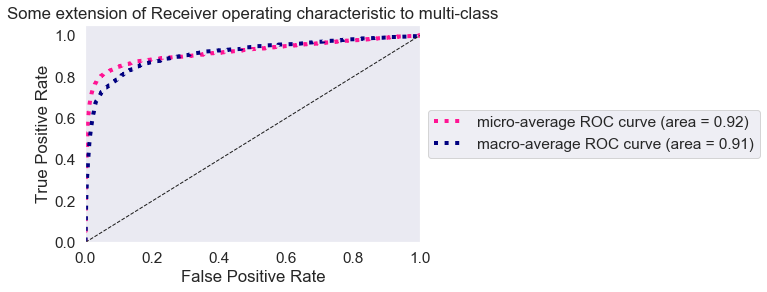

micro-averaged scores over all classes
F1 score: 0.630, 
AUC score: 0.919
--------------------
macro-averaged scores over all classes
F1 score: 0.372, 
AUC score: 0.911
--------------------


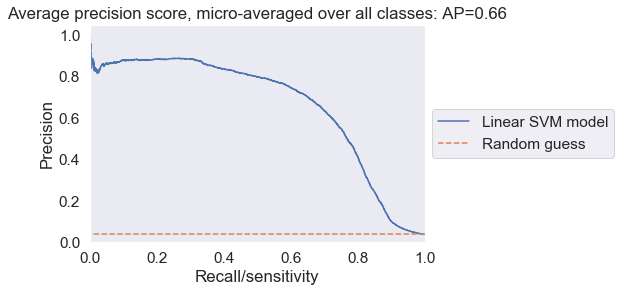

--------------------------------------------------
TN: 183298	 FP: 995 
FN: 3430	 TP: 3767
The sensitivity/recall is: 52.34%
The specificity is: 99.46%
The precision is: 79.11%
--------------------------------------------------


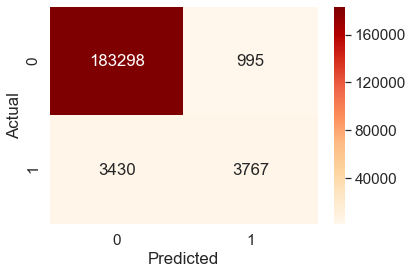

In [856]:
plot_roc_curve(y_test_np, y_scores_linear, show_all_classes = False)
plot_prec_recall(y_test_np, y_scores_linear, y_pred_linear, label_='Linear SVM model')
totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_linear.ravel())
plot_conf_mat(totals_mat)


Training size 15000
Using optimal C: 10.0 and gamma: 0.01
Test accuracy on rbf kernel 88.09%
F1 score: 0.614, 
AUC score: 0.926


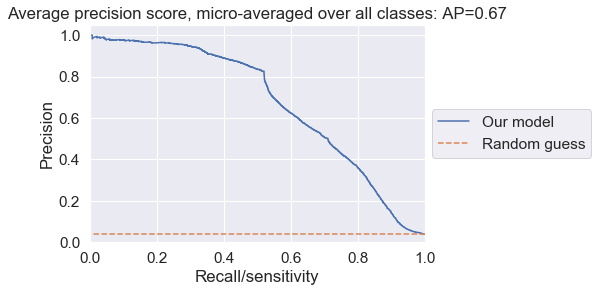

--------------------------------------------------
TN: 182287	 FP: 2006 
FN: 3120	 TP: 4077
The sensitivity/recall is: 56.65%
The specificity is: 98.91%
The precision is: 67.02%
--------------------------------------------------


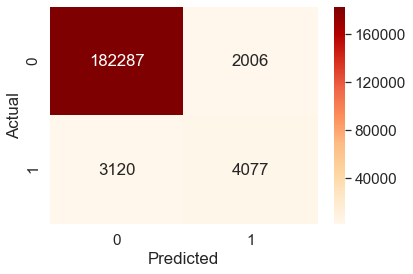

CPU times: user 2min 19s, sys: 1.11 s, total: 2min 20s
Wall time: 2min 14s


In [834]:
%%time
# Tekur ca 8min að keyra á 50þus train size
print('Training size', train_size)
print('Using optimal C: {} and gamma: {}'.format(rbfOptparam[0], rbfOptparam[1]))

x_test_unrvld = vectorizer.transform(X_test_np.ravel())
clf = OneVsRestClassifier(SVC(C = rbfOptparam[0], gamma = rbfOptparam[1], kernel = 'rbf'))
clf.fit(X_train_reduced, y_train_reduced)

y_pred_rbf = clf.predict(vectorizer.transform(X_test_np.ravel()))

test_acc = get_row_accuracy(y_test_np, y_pred_rbf)

print('Test accuracy on rbf kernel {:.2%}'.format(test_acc))

y_scores_rbf = clf.decision_function(vectorizer.transform(X_test_np.ravel()))
calc_precision_recall(y_test_np, y_scores_rbf, y_pred_ = y_pred_rbf)
totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_rbf.ravel())
plot_conf_mat(totals_mat)

In [835]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc_curve(y_true_, y_score_, n_classes = 6, show_all_classes = False):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_[:, i], y_score_[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_.ravel(), y_score_.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    if(show_all_classes):
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'crimson', 'indigo', 'limegreen'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                     label='ROC curve of {} (area = {:0.2f})'
                     ''.format(cols[i+1], roc_auc[i]))
    plt.grid(None) 
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    

--------------------------------------------------
TN: 183389	 FP: 904 
FN: 3514	 TP: 3683
The sensitivity/recall is: 51.17%
The specificity is: 99.51%
The precision is: 80.29%
--------------------------------------------------


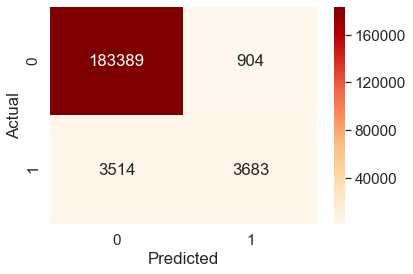

--------------------------------------------------
TN: 183425	 FP: 868 
FN: 3295	 TP: 3902
The sensitivity/recall is: 54.22%
The specificity is: 99.53%
The precision is: 81.80%
--------------------------------------------------


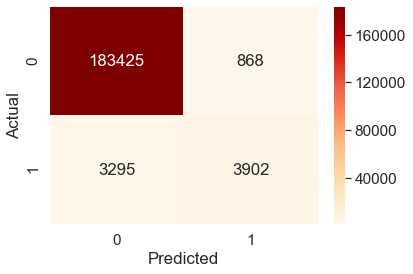

In [809]:
totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_linear.ravel())
plot_conf_mat(totals_mat)
totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_rbf.ravel())
plot_conf_mat(totals_mat)

### Random forrest


Start by finding a optimal number of trees for default values of the random forrest

Data subsampling succsessful!


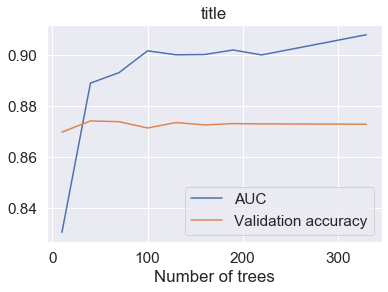

Number of trees for highest AUC 330
CPU times: user 9min 19s, sys: 7.35 s, total: 9min 26s
Wall time: 1min 46s


In [881]:
%%time
train_size = 15000
#tekur um 1min20 sec með 50þús train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)

# Use our best RF model 
auc_scores = []; acc_rf = []
param = np.arange(10, 250, 30).tolist()
param.append(330)
for i in param:

    rf = RandomForestClassifier(n_estimators=i, class_weight = 'balanced', n_jobs = -1)
    rf.fit(X_train_reduced, y_train_reduced)
    y_pred_ = rf.predict(vectorizer.transform(X_test_np.ravel()))
    test_acc = get_row_accuracy(y_test_np, y_pred_)
    acc_rf.append(test_acc)
    
    y_proba = rf.predict_proba(vectorizer.transform(X_test_np.ravel()) )
    y_scores_rf = np.zeros(y_test_np.shape)
    for i in range(len(y_proba)):
        y_scores_rf[:,i] = y_proba[i][:,1]
    auc = roc_auc_score(y_test_np, y_scores_rf, average = 'macro')
    auc_scores.append(auc)
    
plt.plot(param, auc_scores,label='AUC ')
plt.plot(param, acc_rf,label='Validation accuracy')
plt.title('title')
plt.xlabel('Number of trees')
plt.legend()
plt.show()
m =np.argmax(auc_scores)
print('Number of trees for highest AUC', param[m])

In [903]:
%%time
warnings.filterwarnings("ignore") # ignore warnings for the purpose of readability

train_size = 3000
# tekur um 1min+ med 5 þúsund train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)
depth_range = [100]
depth_range.append(np.arange(250, 750, 50).tolist())
features_range = np.arange(5, 20, 5).tolist()
features_range.append('sqrt')
features_range.append(300)


parameters = {
    'max_depth': depth_range,
    'max_features': features_range
}
rf = RandomForestClassifier(n_estimators=100, oob_score=False, class_weight = 'balanced')
grid = GridSearchCV(rf, parameters, verbose=1, n_jobs=-1, scoring = 'roc_auc') #n_jobs=-1 notar alla kjarna
grid.fit(X_train_reduced, y_train_reduced)
print("Optimal parameters for the grid are {}s with a score of {:.2%}".format(grid.best_params_, grid.best_score_))

Data subsampling succsessful!
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
exception calling callback for <Future at 0x1624e9250 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [885]:
# print(grid.cv_results_)
# print(grid.cv_results_['mean_test_score'])
# sama mynd og að ofan, betra að stilla hér
offset = 0.01
scores = grid.cv_results_['mean_test_score'].reshape(len(depth_range),len(features_range))
print(scores)
plot_heatmap(scores, 'Validation accuracy', 'max_features', 'max_depth', 
              features_range, depth_range, np.min(scores), np.median(scores))


AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

Data subsampling succsessful!
Training size:  50000
Using max depth: 550 and max features: 5
Test acc 40.62%
micro-averaged scores over all classes
F1 score: 0.114, 
AUC score: 0.750
--------------------
macro-averaged scores over all classes
F1 score: 0.099, 
AUC score: 0.691
--------------------


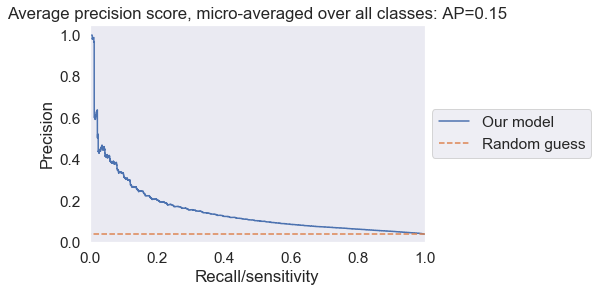

micro-averaged scores over all classes
F1 score: 0.114, 
AUC score: 0.750
--------------------
macro-averaged scores over all classes
F1 score: 0.099, 
AUC score: 0.691
--------------------


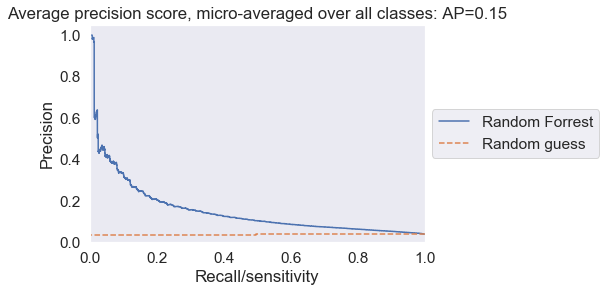

--------------------------------------------------
TN: 95098	 FP: 89195 
FN: 1353	 TP: 5844
The sensitivity/recall is: 81.20%
The specificity is: 51.60%
The precision is: 6.15%
--------------------------------------------------


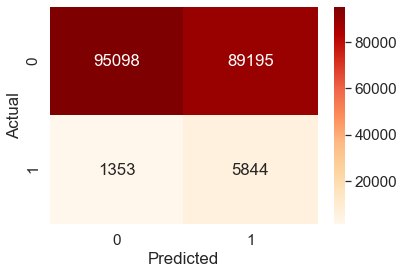

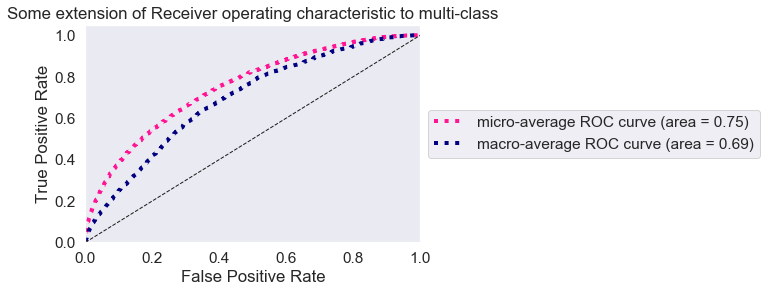

CPU times: user 3min 29s, sys: 3.09 s, total: 3min 33s
Wall time: 43.5 s


In [857]:
%%time
train_size = 50000
#tekur um 1min20 sec með 50þús train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)

# Fit and test it
best_max_depth=grid.best_params_['max_depth']
best_max_features=grid.best_params_['max_features']
# Use our best RF model 
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=best_max_depth,
    max_features=best_max_features,
    oob_score=False,
    class_weight = 'balanced',
    n_jobs = -1
)
print('Training size: ', train_size)
print('Using max depth: {} and max features: {}'.format(best_max_depth, best_max_features))
rf.fit(X_train_reduced, y_train_reduced)
y_pred_rf = rf.predict(vectorizer.transform(X_test_np.ravel()))

test_acc = get_row_accuracy(y_test_np, y_pred_rf)
print('Test acc {:.2%}'.format(test_acc))

y_proba = rf.predict_proba(vectorizer.transform(X_test_np.ravel()) )
y_scores_rf = np.zeros(y_test_np.shape)

for i in range(len(y_proba)):
    y_scores_rf[:,i] = y_proba[i][:,1]
    
calc_precision_recall(y_test_np, y_scores_rf, y_pred_ = y_pred_rf)
plot_prec_recall(y_test_np, y_scores_rf, y_pred_rf, label_='Random Forrest')

totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_rf.ravel())
plot_conf_mat(totals_mat)
plot_roc_curve(y_test_np, y_scores_rf, show_all_classes = False)


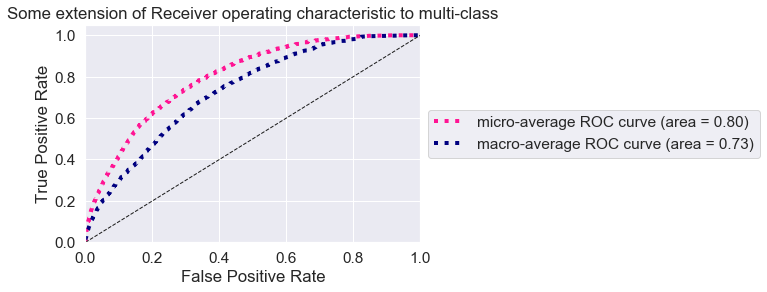

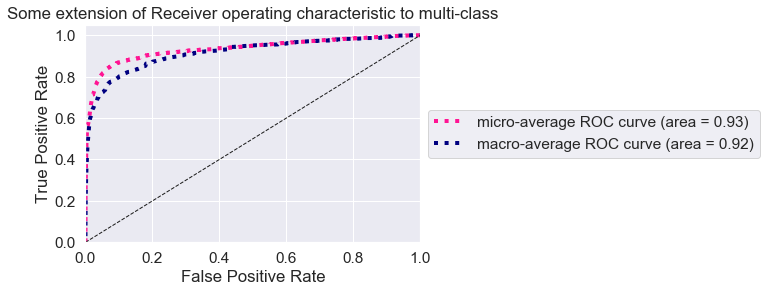

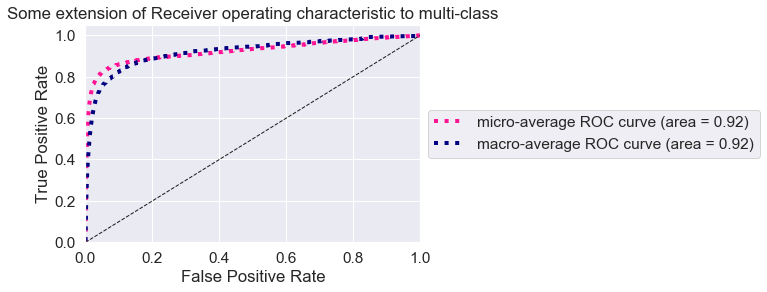

In [824]:
plot_roc_curve(y_test_np, y_scores_rf, show_all_classes = False)
plot_roc_curve(y_test_np, y_scores_rbf, show_all_classes = False)
plot_roc_curve(y_test_np, y_scores_linear, show_all_classes = False)
